In [24]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from publik import modifier
from publik import plot
from knunu_utils import * 

## Produce samples

In [25]:
sam_ana = analysis()
# sam_cvl = 6.0
# sam_csl = 2.0
# sam_ctl = 2.0
# sam_ana.parameters['sbnunu::Re{cVL}'].set(sam_cvl)
# sam_ana.parameters['sbnunu::Re{cSL}'].set(sam_csl)
# sam_ana.parameters['sbnunu::Re{cTL}'].set(sam_ctl)

In [26]:
p = sam_ana.parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})
pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)

null_samples, pdf_values = pdf.sample_mcmc(500000, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [27]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

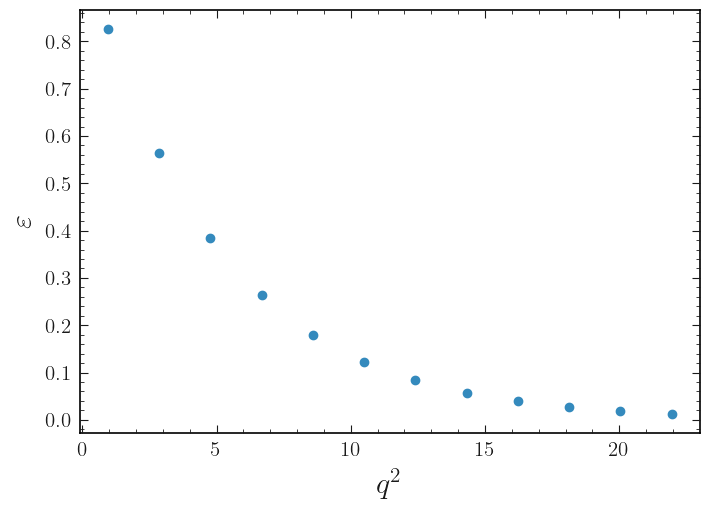

In [28]:
binning = np.linspace(0.0, 22.9, 13) 
bin_cents = (binning[:-1] + binning[1:])/2

plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

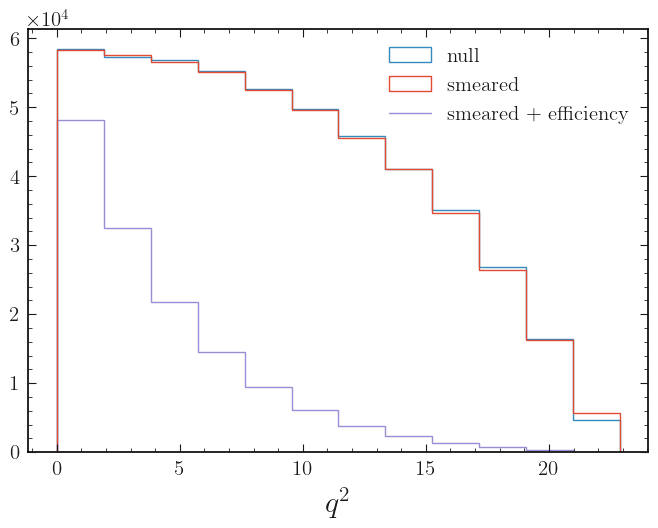

In [29]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

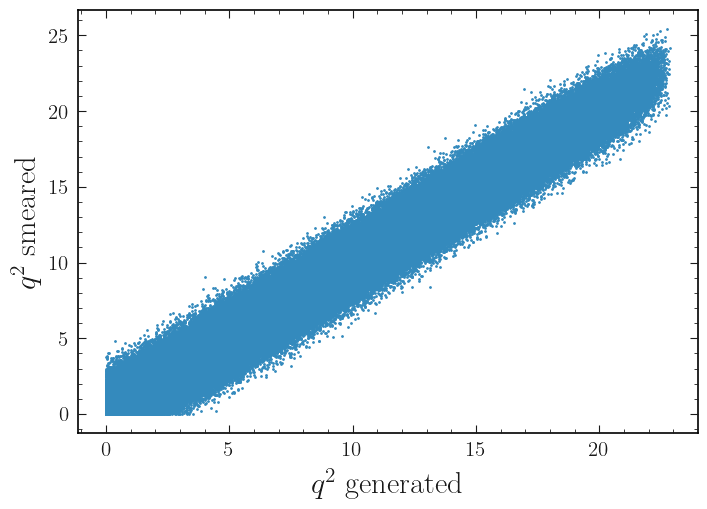

In [30]:
plt.scatter(null_samples, null_samples_smeared, s=1)
plt.xlabel(r'$q^2$ generated')
plt.ylabel(r'$q^2$ smeared')
plt.show()

## Define null and alternative predictions

In [31]:
ana = analysis()
cvl = ana.parameters['sbnunu::Re{cVL}'         ].evaluate()
csl = ana.parameters['sbnunu::Re{cSL}'         ].evaluate()
ctl = ana.parameters['sbnunu::Re{cTL}'         ].evaluate()
fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [32]:
null = null_pred()
alt = alt_pred()

## Get covariance matrix of hadronic parameters

In [33]:
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


## Set up mapping distribution

In [34]:
mapping_dist = np.histogram2d(null_samples.flatten(), null_samples_smeared.flatten(), bins=binning)[0].T
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [35]:
# TODO Why do I have to initialize csl and ctl to > 0. for the fit to work properly?
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.1,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.1,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [binning])
cmod.expanded_pyhf

{'custom': (publik.custom_modifier.add.<locals>._builder,
  publik.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

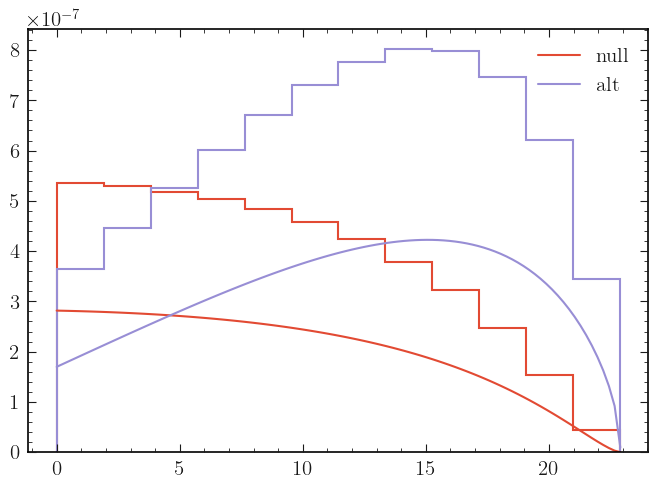

weights :  [0.68205075 0.84446179 1.01411677 1.19322938 1.38516801 1.59532707
 1.83293338 2.11522554 2.47869363 3.01679801 4.06251709 7.8291499 ]


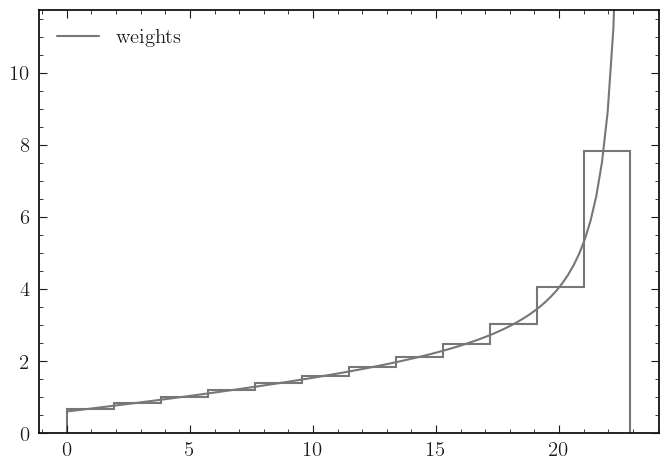

weights :  [0.68205075 0.84446179 1.01411677 1.19322938 1.38516801 1.59532707
 1.83293338 2.11522554 2.47869363 3.01679801 4.06251709 7.8291499 ]


In [48]:
cvl = 5.
csl = 3.
ctl = 2.

pars = (cvl, csl, ctl,fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
plot.dists(cmod, pars, lims)
plot.dists(cmod, pars, lims, plot_dists=False, plot_weights=True)

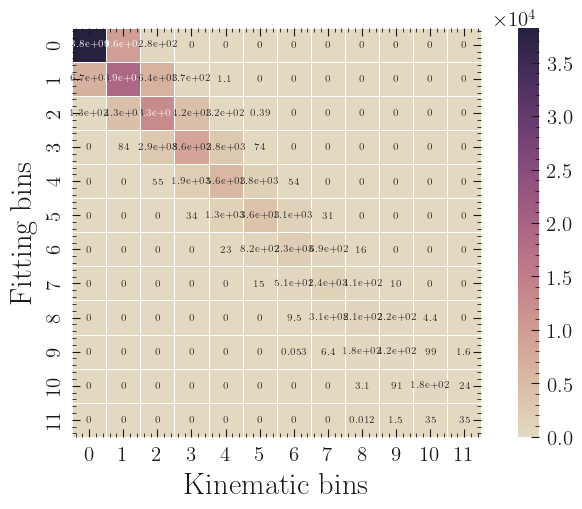

In [37]:
plot.map(cmod)

In [38]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(binning)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [48185.60440807386,
      32451.186924797297,
      21785.430732108987,
      14497.402957593224,
      9434.377890336807,
      6079.637834380309,
      3816.5142516214837,
      2345.2412458338003,
      1352.7124770041962,
      704.4944938962736,
      294.3508938283705,
      71.01612805455957],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [219.51219649047718,
        180.14212978866797,
        147.59888458965057,
        120.40516167338185,
        97.13072577890483,
        77.97203238585172,
        61.77794308344592,
        48.427690899255154,
        36.7792397556583,
        26.542315157052023,
        17.156657420032914,
        8.427106742800852]},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}}

In [39]:
model.config.par_map

{'cvl': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x148325c7f160>},
 'csl': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x148325c7f190>},
 'ctl': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x148325c7f1c0>},
 'FF_decorrelated[0]': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x148325c7f220>},
 'FF_decorrelated[1]': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x148325c7f1f0>},
 'FF_decorrelated[2]': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x148325c7f250>},
 'FF_decorrelated[3]': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x148325c7f280>},
 'FF_decorrelated[4]': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at

## Generate some fake data

Alternative yields 
 [34523.53508017 27472.61257626 22121.44033549 17312.02006418
 13071.83944653  9705.73864629  6996.49066464  4969.78659717
  3359.71219743  2135.76346706  1186.51200353   416.9331625 ]


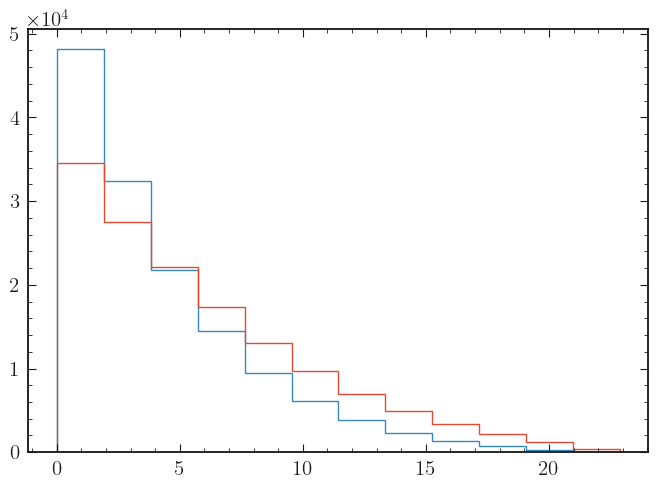

In [40]:
init = model.config.suggested_init()
init[0] = 5. # cvl
init[1] = 3. # csl
init[2] = 2. # ctl
alt_yields = model.expected_actualdata(init)

print('Alternative yields \n', alt_yields)

plt.stairs(null_yields, binning)
plt.stairs(alt_yields, binning)

In [41]:
#Save and load model
modifier.save('knunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [42]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.244125


{'cvl': array([4.99979987, 0.16126142]),
 'csl': array([2.99982675, 0.17532335]),
 'ctl': array([2.00079823, 0.16667027]),
 'FF_decorrelated[0]': array([-0.00196054,  0.92263469]),
 'FF_decorrelated[1]': array([-0.00890805,  0.97861538]),
 'FF_decorrelated[2]': array([-0.00143959,  0.97793953]),
 'FF_decorrelated[3]': array([0.00188102, 0.98262608]),
 'FF_decorrelated[4]': array([7.57545032e-04, 9.91796369e-01]),
 'FF_decorrelated[5]': array([-1.26649769e-04,  9.82125830e-01]),
 'FF_decorrelated[6]': array([-0.00722562,  0.99462533]),
 'FF_decorrelated[7]': array([0.00461842, 0.9933107 ]),
 'mu': array([1., 0.]),
 'stat': [[0.9999995296648065, 0.0043624565722265585],
  [1.0000087657902437, 0.004558182188732163],
  [1.0000102701327231, 0.005408448840928004],
  [1.000002814411366, 0.006407630124755925],
  [0.9999937249889419, 0.007605234602193478],
  [0.999989429768881, 0.009092251123481998],
  [0.9999914074884737, 0.011020681578779168],
  [0.9999944409168642, 0.013580646310814126],
  [0

In [43]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 4.99979986883248,
 'csl': 2.99982674651255,
 'ctl': 2.0007982270591973,
 'FF[0]': 0.3379941728959957,
 'FF[1]': -0.8838956228270134,
 'FF[2]': -0.10872018758626036,
 'FF[3]': 0.37451424014245077,
 'FF[4]': 0.07938657289368048,
 'FF[5]': 0.32677472244475275,
 'FF[6]': -0.9628206967813655,
 'FF[7]': -0.27799730748128515,
 'mu': 1.0,
 'stat': [0.9999995296648065,
  1.0000087657902437,
  1.0000102701327231,
  1.000002814411366,
  0.9999937249889419,
  0.999989429768881,
  0.9999914074884737,
  0.9999944409168642,
  0.9999896987942872,
  0.9999785953360047,
  0.9999996116503825,
  1.0000499265903338]}

In [44]:
# TODO compute chi square between FF parameters

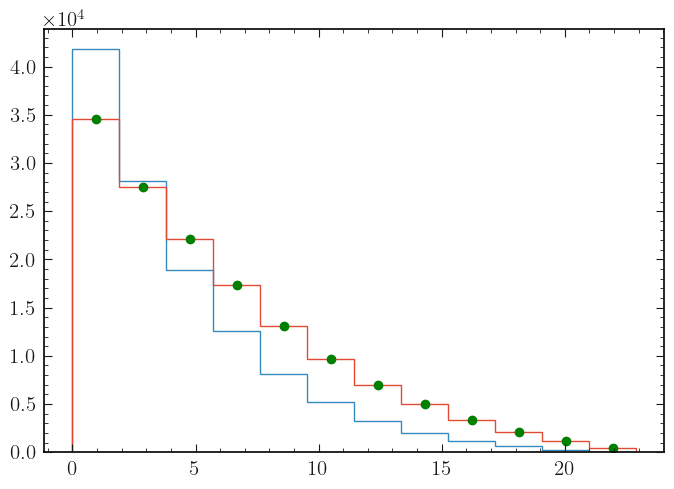

In [45]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')